In [1]:
import numpy as np
import time
import generalized_genSim_shorten_time_HMM as ggsdHMM
import numpy as np
import curve_fitting as cf
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm as cmx
from scipy import optimize, stats
import bluepyopt as bpop
import bluepyopt.deapext.algorithms as algo
import vclamp_evaluator_HMMtoHH as vcl_ev
import pickle
import time
from deap import tools
#from deap import base, creator
import multiprocessing
#import eval_helper as eh
#import scoring_functions_relative as sf
#import curve_fitting as cf
import generalized_genSim_shorten_time as ggsd
import eval_helper_na12mut8st as ehn

Reached import hoc
Reached import neuron.hoc


In [2]:
ehn.find_tau0()

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [3]:
inactivation = ggsdHMM.Inactivation(channel_name='na12mut8st')
inactivation.genInactivation()
inactivation.get_just_tau0()

14.41747057097154

In [5]:
ehn.find_tau0()

0.4231792451831216

In [2]:
evaluator = vcl_ev.Vclamp_evaluator_HMM('./csv_files/params_na12mut8st_mod.csv', 'Basis', 'na12mut8st', 'na12mut', objective_names=['act', 'inact', 'tau0'])


#evaluator = vcl_ev.Vclamp_evaluator_HMM('./param_stats_narrow.csv', 'A427D', 'na', objective_names=['v_half_act', 'gv_slope', 'v_half_ssi', 'ssi_slope'])

In [3]:
evaluator.wild_data



{'v_half_act': -19.438432175828535,
 'gv_slope': 6.1618554048712015,
 'v_half_ssi': -44.72164146029349,
 'ssi_slope': 7.055442056187008,
 'tau_fast': 0.8927258721940866,
 'tau_slow': 1.1909104890546904,
 'percent_fast': 0.002371458641170018,
 'tau0': 9999999999}

In [4]:
gen_counter = 0
best_indvs = []
cp_freq = 1
old_update = algo._update_history_and_hof
def my_update(halloffame, history, population):
    global gen_counter,cp_freq
    if halloffame is not None:
        halloffame.update(population)
    
    if halloffame:
        best_indvs.append(halloffame[0])
    gen_counter = gen_counter+1
    print("Current generation: ", gen_counter)
    if gen_counter%cp_freq == 0:
        fn = '.pkl'
        save_logs(fn,best_indvs,population)

def my_record_stats(stats, logbook, gen, population, invalid_count):
    '''Update the statistics with the new population'''
    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=gen, nevals=invalid_count, **record)
    print('log: \n', logbook, '\n')
    output = open("log.pkl", 'wb')
    pickle.dump(logbook, output)
    output.close()

def save_logs(fn, best_indvs, hof):
    output = open("indv"+fn, 'wb')
    pickle.dump(best_indvs, output)
    output.close()
    output = open("hof"+fn, 'wb')
    pickle.dump(hof, output)


In [5]:
#hof = tools.HallOfFame(1, similar=np.array_equal)
hof = tools.ParetoFront()
algo._update_history_and_hof = my_update
algo._record_stats = my_record_stats
pool = multiprocessing.Pool(processes=64)
deap_opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=100, hof = hof, map_function=pool.map)  # CHANGE offspring_size

cp_file = './cp.pkl'

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.ts

Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.1250570297212883, 0.17405028659282087, 0.08954160373053874, 0.038296441204970715, 0.015607359834493401, 0.006275167261480983, 0.00251336766058994, 0.0010055969750388278, 0.00040223036338481123, 0.0001608831875451117, 6.435270089074672e-05, 2.5743320541027268e-05, 1.0299803732503236e-05, 4.121900639805438e-06, 1.650173428435762e-06, 6.610268163391182e-07, 2.650417870552301e-07, 1.0642635515254897e-07, 4.2834218110102506e-08, 1.730269756887767e-08, 7.029283939438274e-09, 2.881090673559893e-09, 1.197109097341728e-09, 5.078336938745025e-10, 2.2218182021548814e-10, 1.0162434745598397e-10, 4.941546593859557e-11, 2.600968970200264e-11, 1.505170201609086e-11, 9.65914837135394e-12, 6.863705635811825e-12, 5.341748493279469e-12, 4.47759735720438e-12, 3.970434385385536e-12, 3.66543163565364e-12, 3.478837191373906e-12, 3.3633498332173916e-12, 3.2913212343665523e-12, 3.2461723868288058e-12, 3.2177809575788535e-12, 3.1998904316560064e-12, 3.1886021090215124e-12, 3.1814736086335004e-12, 3.176969623

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


[0.15220771124289426, 0.23450710553014667, 0.1382221417746891, 0.06876827256006139, 0.03282791575025495, 0.01550426208223783, 0.00730226847964116, 0.003436929719344971, 0.0016174409778746592, 0.0007611935460912873, 0.00035825416463660965, 0.00016862806433675558, 7.9382870434617e-05, 3.737708930802871e-05, 1.760357083022731e-05, 8.294002554621207e-06, 3.9099488979251585e-06, 1.844724460792528e-06, 8.713754199663697e-07, 4.123102801719961e-07, 1.9557922012769872e-07, 9.310694017101355e-08, 4.455428360372784e-08, 2.1479179294979843e-08, 1.046466444779478e-08, 5.1745655802915795e-09, 2.6118318327483437e-09, 1.3555670937994095e-09, 7.298944597477692e-10, 4.1179966835660253e-10, 2.4587642725801327e-10, 1.5665990622459116e-10, 1.0703702436234397e-10, 7.844498472403068e-11, 6.1395222420538e-11, 5.0905871707079626e-11, 4.427809375996425e-11, 3.9998706257226203e-11, 3.718882947511366e-11, 3.5320453060464645e-11, 3.406661020024297e-11, 3.3219589653692563e-11, 3.26447080561686e-11, 3.2253246606497

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[2.4083323937556527, 70.4299662335491, 87.63486641289724, 89.36450679388078, 89.52048834021237, 89.53274595928347, 89.53335155942803, 89.53329777556627, 89.53327137064518, 89.5332648690461, 89.53326351041399, 89.53326324460797, 89.53326319419976, 89.53326318479013, 89.53326318304823, 89.53326318272715, 89.53326318266826, 89.53326318265741, 89.53326318265542, 89.53326318265505, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499, 89.53326318265499]
Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mike

Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.13076877537733084, 0.18594847948432153, 0.09851934787233613, 0.04354405425380145, 0.018368347874553183, 0.007649438030333467, 0.0031742304904561684, 0.0013159144363083435, 0.0005454009250960358, 0.00022604507718259687, 9.369070139314711e-05, 3.8836411563140195e-05, 1.6100713223647796e-05, 6.676485535842026e-06, 2.7694879126291804e-06, 1.1494255195815884e-06, 4.774390080197349e-07, 1.9856637683021306e-07, 8.274572297922148e-08, 3.4586060133313525e-08, 1.4523859767275324e-08, 6.142793768389985e-09, 2.6264447647620837e-09, 1.14147151128804e-09, 5.082177926111387e-10, 2.3429260615629696e-10, 1.1337420796919168e-10, 5.850043119929644e-11, 3.269355585514636e-11, 2.0024854445093612e-11, 1.3504034626568346e-11, 9.983684548358555e-12, 7.99819493066999e-12, 6.836376244365808e-12, 6.1366678305330215e-12, 5.706209867914574e-12, 5.437381862364991e-12, 5.2677546124146646e-12, 5.1599786416889945e-12, 5.0911868537842984e-12, 5.047146144767137e-12, 5.018896002757064e-12, 5.000751821283415e-12, 4.989

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.11358523421747117, 0.15146511682844077, 0.07336037419634944, 0.029322146003349037, 0.011128900371139115, 0.004160820849011857, 0.0015487380149543529, 0.0005757224482335396, 0.0002139405770550112, 7.949575252535016e-05, 2.954002762419844e-05, 1.0977957963791289e-05, 4.080446590451964e-06, 1.5171129372388142e-06, 5.643273937414076e-07, 2.1007605690640935e-07, 7.830068275021736e-08, 2.92444241187409e-08, 1.0958978709982532e-08, 4.12908150979652e-09, 1.5694432674589694e-09, 6.049752504298594e-10, 2.384270037416093e-10, 9.723349768843631e-11, 4.172228425185447e-11, 1.923696519663394e-11, 9.748518167416785e-12, 5.5317780054776875e-12, 3.5436431946370495e-12, 2.5480801854604152e-12, 2.0216028613577692e-12, 1.7305504514175814e-12, 1.5642356416776859e-12, 1.4669819943132096e-12, 1.4092336485637924e-12, 1.3746029177393223e-12, 1.3537056639902772e-12, 1.3410466066186046e-12, 1.3333596604278555e-12, 1.3286850483426094e-12, 1.3258397428719241e-12, 1.3241069304281948e-12, 1.3230512794402454e-12, 

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12202247355163806, 0.16802030138915794, 0.08507937219944615, 0.0357377529792671, 0.014289017368736112, 0.005633642880746588, 0.002212190973368239, 0.0008676939150603628, 0.0003402544471105507, 0.00013343449814091798, 5.233996319617664e-05, 2.0538880199364396e-05, 8.065088393372286e-06, 3.1703244958894295e-06, 1.2483454307522197e-06, 4.928748522151632e-07, 1.9543144506685906e-07, 7.801548439630458e-08, 3.147428053560456e-08, 1.2907477984221493e-08, 5.426991377453059e-09, 2.367869298516906e-09, 1.0892793969889842e-09, 5.383350486734084e-10, 2.9121863483512463e-10, 1.7484633430900124e-10, 1.1701715457387798e-10, 8.670252411531088e-11, 7.003229722942476e-11, 6.050054237370037e-11, 5.488770111215943e-11, 5.151269129179613e-11, 4.945418366540426e-11, 4.818676539593069e-11, 4.740163899126824e-11, 4.691337227674542e-11, 4.660896657143339e-11, 4.6418889605648065e-11, 4.6300084541936194e-11, 4.622578095034168e-11, 4.6179291579141956e-11, 4.6150197571304666e-11, 4.613198715996381e-11, 4.612058

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12431031163140116, 0.17252699887720224, 0.08841444672095242, 0.037650677211395506, 0.015274465918042634, 0.006112856874455688, 0.0024369214607778784, 0.0009704431386133465, 0.0003863486294112034, 0.00015380580934288277, 6.123308640762204e-05, 2.4380427663256188e-05, 9.708755442943343e-06, 3.867150471035183e-06, 1.5409346760106306e-06, 6.143824984499151e-07, 2.4519215708856823e-07, 9.800020507424427e-08, 3.926243258235784e-08, 1.578877595342785e-08, 6.386480230260353e-09, 2.6069703448709833e-09, 1.0792592185762492e-09, 4.5647584200149035e-10, 1.9931954005473954e-10, 9.111910403654792e-11, 4.436626261664916e-11, 2.3432407424849514e-11, 1.3633582480600514e-11, 8.808199084436336e-12, 6.303892073899826e-12, 4.938876394073565e-12, 4.163244323589487e-12, 3.7079500059963625e-12, 3.434256652348479e-12, 3.2669761379135674e-12, 3.1635843015505773e-12, 3.0992076830276194e-12, 3.0589316797988014e-12, 3.0336562857771776e-12, 3.017763491513392e-12, 3.0077578898548015e-12, 3.001453707748888e-12, 2.

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.
[0.13654745039011928, 0.1984306997755114, 0.108262831838146, 0.04944024152271207, 0.021581614965277527, 0.009306409515563519, 0.003999779120959544, 0.0017175497057218116, 0.0007373881296791817, 0.0003165770702993812, 0.00013592112311418587, 5.836270937666077e-05, 2.5063683017954868e-05, 1.0765769837698034e-05, 4.625747551645716e-06, 1.9885011160567435e-06, 8.554300216375781e-07, 3.6840192019886276e-07, 1.58923148442863e-07, 6.87317610447214e-08, 2.9840161480768644e-08, 1.3030734678765987e-08, 5.740118697187274e-09, 2.5615063591409743e-09, 1.1649649902823945e-09, 5.444783816575912e-10, 2.643721978045051e-10, 1.3512419603136892e-10, 7.374154635362147e-11, 4.352629131985819e-11, 2.8023264978502447e-11, 1.970904367491909e-11, 1.505289691612996e-11, 1.2341897728279012e-11, 1.0711483434510425e-11, 9.705839999812807e-12, 9.073817563614046e-12, 8.67125365004188e-12, 8.412446566139315e-12, 8.245002352364217e-12, 8.136205660676337e-12, 8.06531391112885e-12, 8.0190

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.1328848604964338, 0.19046736334447092, 0.10200873069462595, 0.04563217677361612, 0.019493407781879465, 0.008222921456472018, 0.003456638683332873, 0.0014517001952905162, 0.0006095430971486921, 0.0002559322133943769, 0.00010746534877789719, 4.5128720159057536e-05, 1.895396213578136e-05, 7.962352631634783e-06, 3.3460068093380155e-06, 1.4068025345990995e-06, 5.919419526054362e-07, 2.493719387896597e-07, 1.0524929442627036e-07, 4.4547495829657626e-08, 1.893709376954541e-08, 8.103567190738923e-09, 3.5025589421359766e-09, 1.5367459953790617e-09, 6.893056618140575e-10, 3.191872254284165e-10, 1.545118879072191e-10, 7.935838496944942e-11, 4.3907689136136265e-11, 2.649817991282261e-11, 1.7552314494330913e-11, 1.2736007721841682e-11, 1.0026794036974976e-11, 8.444128110390985e-12, 7.491175083909763e-12, 6.904162473114612e-12, 6.5365932278347814e-12, 6.303794682429667e-12, 6.155206581891446e-12, 6.059875148124318e-12, 5.9985024270882176e-12, 5.958902779288734e-12, 5.9333142271148305e-12, 5.91676

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/curve_fitting.py:27: RuntimeWarning: invalid value encountered in add
  return y0 + span_fast * (1 - np.exp(-k_fast * x)) + span_slow * (1 - np.exp(-k_slow * x))


Couldn't fit curve to recovery.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


[0.12618958515813183, 0.17637487050945344, 0.09127147443958439, 0.03929327066019203, 0.016124260100827403, 0.006528690098810828, 0.002633484114634881, 0.0010611614477054583, 0.00042748266917388354, 0.00017220340205845562, 6.93722271910984e-05, 2.794931005678062e-05, 1.1262179691844984e-05, 4.5391695833645104e-06, 1.83016695676283e-06, 7.383401873718573e-07, 2.9813798847289564e-07, 1.2055868695798705e-07, 4.8859940961290065e-08, 1.987150633369081e-08, 8.126146813613826e-09, 3.351376618295049e-09, 1.4003144255903522e-09, 5.967826898552274e-10, 2.6191824254236337e-10, 1.199238722136498e-10, 5.821485484086073e-11, 3.049355469497772e-11, 1.7509072921031575e-11, 1.1124855895425592e-11, 7.820837843506906e-12, 6.025113778637956e-12, 5.006762675236739e-12, 4.4093243882858544e-12, 4.049838326182605e-12, 3.829615718961374e-12, 3.693043041728579e-12, 3.607652355647796e-12, 3.553976564393177e-12, 3.52011947580599e-12, 3.4987158584322116e-12, 3.485165737004459e-12, 3.4765796814561935e-12, 3.47113596

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.
Couldn't fit curve to recovery.
[0.15891403308129942, 0.24862749957596283, 0.15019070444688548, 0.07681039140995798, 0.03773637399830394, 0.018350202057427052, 0.008899811595884086, 0.004313636070934504, 0.002090520280794552, 0.0010131508314004819, 0.0004910468262010042, 0.00023802027527078636, 0.00011538865529126563, 5.594911092405804e-05, 2.713547822219546e-05, 1.3165709920882727e-05, 6.391212335253714e-06, 3.104948609857682e-06, 1.5100839206443884e-06, 7.355766418290446e-07, 3.5910911131341807e-07, 1.7587734659044085e-07, 8.652890045582721e-08, 4.284453160031921e-08, 2.1406198801710077e-08, 1.0829953498717197e-08, 5.574346282360515e-09, 2.9367215572745206e-09, 1.5953444696696804e-09, 9.013263067364281e-10, 5.343833961812105e-10, 3.3524562555708247e-10, 2.2390363984352305e-10, 1.5961675171177078e-10, 1.2127185985099282e-10, 9.768370818388362e-11, 8.276790357395359e-11, 7.31136985888776e-11, 6.674645507724241e-11, 6.248525420740983e-11, 5.96018825422002

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.1388470213615496, 0.20352249526821897, 0.11233113175374396, 0.051961346586472716, 0.02298894431481732, 0.010049796592421315, 0.004379159760490737, 0.001906593970110531, 0.0008299357449823385, 0.00036126779793529544, 0.00015726749929909593, 6.846832856935171e-05, 2.981265498243013e-05, 1.298375569268922e-05, 5.656301401099232e-06, 2.4652677373384236e-06, 1.0752178206828872e-06, 4.694433535189089e-07, 2.0528444633498414e-07, 8.998363983390688e-08, 3.958473104086692e-08, 1.7507542819410634e-08, 7.805504228015413e-09, 3.5214282613884467e-09, 1.6163898650633337e-09, 7.605825151802929e-10, 3.70521798683826e-10, 1.8915781022502876e-10, 1.0257354112922481e-10, 5.984398870576848e-11, 3.791853610441735e-11, 2.618031468178276e-11, 1.9623037255900967e-11, 1.5813544433583952e-11, 1.3525124704613132e-11, 1.2113231195063142e-11, 1.1224345497573637e-11, 1.0656451873642646e-11, 1.0289858764773472e-11, 1.005151433940179e-11, 9.89579722220009e-12, 9.79372940608115e-12, 9.726680511497933e-12, 9.6825715

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.
[0.12282448009140708, 0.16951804036196205, 0.08620297493326326, 0.03639240059543733, 0.01463033489509449, 0.005800992856041335, 0.0022910662286624206, 0.0009038411445236635, 0.0003564698015849537, 0.00014058395758715403, 5.544575685049064e-05, 2.1869699757340258e-05, 8.627508216568762e-06, 3.4043597309135867e-06, 1.3438648335164302e-06, 5.308178524563662e-07, 2.0987649432218048e-07, 8.311166177954182e-08, 3.2994214611351045e-08, 1.3149751499655531e-08, 5.273275271881464e-09, 2.1352130779860036e-09, 8.776142207560959e-10, 3.6904545610742997e-10, 1.6055331503908605e-10, 7.334808618669897e-11, 3.582684995255353e-11, 1.9063423336103628e-11, 1.1217515505043737e-11, 7.347753989518454e-12, 5.334571322663281e-12, 4.234760206547859e-12, 3.6089460160335807e-12, 3.2415215194260525e-12, 3.0208733520889115e-12, 2.886289792198529e-12, 2.8033439698851468e-12, 2.751875289437073e-12, 2.7197986756314472e-12, 2.6997519079030774e-12, 2.6872012076230206e-12, 2.67933479454013

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpac

Couldn't fit curve to recovery.
Couldn't fit curve to recovery.
[0.1262573772783861, 0.17651455775996724, 0.09137580044739135, 0.03935360966365559, 0.016155665393907646, 0.0065441511737630905, 0.002640836917012819, 0.001064575531640944, 0.00042904007813639704, 0.00017290417730733197, 6.968412125133233e-05, 2.808689339939466e-05, 1.1322424950491406e-05, 4.5653880472554235e-06, 1.8415185802906826e-06, 7.432341589512138e-07, 3.002407246757555e-07, 1.2145986638252944e-07, 4.9245581918869155e-08, 2.0036496968821916e-08, 8.19684297040924e-09, 3.381789690343559e-09, 1.4134966871965526e-09, 6.025689474900369e-10, 2.6450891190476845e-10, 1.2111865416957867e-10, 5.878958890754162e-11, 3.0786151418427244e-11, 1.7669060145314397e-11, 1.1219941167439941e-11, 7.882654363322697e-12, 6.069036604710335e-12, 5.040615244112808e-12, 4.437284688553055e-12, 4.0742429845103365e-12, 3.851825082160373e-12, 3.713874947868301e-12, 3.6276104488322597e-12, 3.5733763322475564e-12, 3.5391608487030015e-12, 3.51752651

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12759489586735306, 0.1792830996947937, 0.09345225584274919, 0.040559769489583064, 0.016786208714011257, 0.006855947341224534, 0.00278977617313282, 0.0011340394030019258, 0.00046086873713641324, 0.00018728976000425678, 7.611530541612189e-05, 3.0936513031603504e-05, 1.2575805677106616e-05, 5.113296560967055e-06, 2.07980558137165e-06, 8.464259298672125e-07, 3.447763137222608e-07, 1.4063181610326746e-07, 5.748617108170093e-08, 2.357754139515778e-08, 9.720629721955037e-09, 4.0400170102586614e-09, 1.6999005164655047e-09, 7.287162008759281e-10, 3.2114627906301534e-10, 1.4728732928764574e-10, 7.138480684697163e-11, 3.719185342212037e-11, 2.11620283827927e-11, 1.3286987396304129e-11, 9.219174936463821e-12, 7.013040275691999e-12, 5.763950466213517e-12, 5.031599336816203e-12, 4.590719526309946e-12, 4.320228124815217e-12, 4.152089133560369e-12, 4.046650336003408e-12, 3.98014592788798e-12, 3.938040167267249e-12, 3.9113166410176175e-12, 3.894329171510986e-12, 3.88351977762999e-12, 3.8766371537233

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.13775504458243173, 0.20109575118136072, 0.11038547953375918, 0.05075137963502796, 0.02231110774376185, 0.00969046583271659, 0.004195124011710658, 0.0018145631043845595, 0.0007847217492726396, 0.0003393570467758714, 0.0001467650475670462, 6.347890186631059e-05, 2.7459757975620585e-05, 1.1881018785688214e-05, 5.142154119533849e-06, 2.226585727448594e-06, 9.648082754150556e-07, 4.185123603630335e-07, 1.818364758309723e-07, 7.919922542438282e-08, 3.462353794656614e-08, 1.5221005064161696e-08, 6.74737126770814e-09, 3.028234416243e-09, 1.383859118102434e-09, 6.490292628578788e-10, 3.156439744966375e-10, 1.6120335807247595e-10, 8.766138917795414e-11, 5.141590967950468e-11, 3.282002420531982e-11, 2.2856919981908624e-11, 1.7284877988478e-11, 1.4044360101858735e-11, 1.2096604423635384e-11, 1.0894990783313508e-11, 1.0139075293909276e-11, 9.656805563639206e-12, 9.346075646635937e-12, 9.144513107982326e-12, 9.013165771586155e-12, 8.927311335502977e-12, 8.87107851712598e-12, 8.834197389887613e-12

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.14885528973529738, 0.22650874273705826, 0.13135532780416687, 0.0641871818858059, 0.03007194880100666, 0.013934686892520257, 0.006438500578468309, 0.002972775249761602, 0.0013723930595876904, 0.000633579967942647, 0.0002925180465866789, 0.00013506590503601203, 6.237306979760926e-05, 2.8809199374547414e-05, 1.3310198271603757e-05, 6.151932760301509e-06, 2.8450692649991804e-06, 1.3168817199624087e-06, 6.103052854878144e-07, 2.833662435960737e-07, 1.3192289681804536e-07, 6.165958961619184e-08, 2.8984331517042893e-08, 1.3737614878716861e-08, 6.588619223529829e-09, 3.213239208263436e-09, 1.603973355890313e-09, 8.263748791430023e-10, 4.4382625518878146e-10, 2.512050586156666e-10, 1.5139711240480562e-10, 9.792489902114033e-11, 6.821414109180729e-11, 5.1083666589359514e-11, 4.085539271643507e-11, 3.4557203102401027e-11, 3.057863593953456e-11, 2.8014246602942615e-11, 2.633598145503451e-11, 2.5225287634158223e-11, 2.4484298495406684e-11, 2.3987148779553396e-11, 2.365227852118926e-11, 2.3426099

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.ts

[0.14822148931310838, 0.22501336503617897, 0.13008546732789902, 0.06334951027346775, 0.0295737540059704, 0.013654216539240259, 0.006285933950254625, 0.002891741278536588, 0.0013301082891930267, 0.0006118156611764858, 0.00028143769374677194, 0.000129474930021421, 5.9572724496115944e-05, 2.7415247535617252e-05, 1.2619924497984098e-05, 5.811607808509638e-06, 2.6778876446156357e-06, 1.2349948422525502e-06, 5.702842379236416e-07, 2.638334930756665e-07, 1.2239362899573215e-07, 5.7006862565499985e-08, 2.670711392865159e-08, 1.261795373236325e-08, 6.033966462858659e-09, 2.935322397484815e-09, 1.462386078807767e-09, 7.525438602098826e-10, 4.0409976360882383e-10, 2.2894404188122395e-10, 1.3828317892206653e-10, 8.97351244628905e-11, 6.276069302594883e-11, 4.7203728032193084e-11, 3.791192962950409e-11, 3.2189290111092674e-11, 2.8574543470758096e-11, 2.624553644364915e-11, 2.4722359914343423e-11, 2.3715266611444988e-11, 2.3044182998867835e-11, 2.2594541930736485e-11, 2.2292120856206675e-11, 2.20881

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.13286945612477138, 0.19043425056755772, 0.10198300399849913, 0.045616684445165104, 0.01948500749954442, 0.008218612159784653, 0.003454503037768834, 0.0014506667974873043, 0.000609051836232318, 0.0002557018562875614, 0.00010735850726535377, 4.507960617379294e-05, 1.8931551010822858e-05, 7.95218916865246e-06, 3.3414214560321477e-06, 1.4047426958365834e-06, 5.910198644483624e-07, 2.489602744060903e-07, 1.0506583642891551e-07, 4.446579515053166e-08, 1.8900683340127195e-08, 8.08729755121511e-09, 3.495249865614312e-09, 1.5334320125043604e-09, 6.877809575484572e-10, 3.184701313312598e-10, 1.5416377595157945e-10, 7.918188673889469e-11, 4.3813000294685706e-11, 2.644375736732597e-11, 1.751849037114219e-11, 1.271318227376346e-11, 1.001010299862044e-11, 8.43100000267159e-12, 7.480189408045224e-12, 6.8945011467211655e-12, 6.527767704174796e-12, 6.295504535369876e-12, 6.147262914205e-12, 6.05215726674916e-12, 5.990932349444514e-12, 5.951429736711842e-12, 5.9259050054252e-12, 5.9093963338552505e-1

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.15143558508529903, 0.23265173977895084, 0.13661810534097785, 0.06769048312643862, 0.032174817817362124, 0.015129607754475078, 0.007094593980903556, 0.0033245274150567033, 0.0015576716718556183, 0.0007298443547814524, 0.00034199030795708965, 0.00016026535081155413, 7.511449912537803e-05, 3.521192837391034e-05, 1.651098483680352e-05, 7.745070903677523e-06, 3.6351603638835314e-06, 1.707573103175797e-06, 8.030737618111389e-07, 3.78345415906958e-07, 1.7869842740697688e-07, 8.471207888903211e-08, 4.037086864114483e-08, 1.9386064034325613e-08, 9.41043037422936e-09, 4.63817264740965e-09, 2.334860480450397e-09, 1.2095642205522037e-09, 6.50750423288045e-10, 3.6731117444535535e-10, 2.1971263357691807e-10, 1.4042812651849727e-10, 9.6346722745245e-11, 7.094675550214539e-11, 5.5797140846516e-11, 4.647519962946123e-11, 4.0585361454522734e-11, 3.678385038387533e-11, 3.4289532593460465e-11, 3.263269881000963e-11, 3.1522277573719193e-11, 3.0773295494926837e-11, 3.0265822556655214e-11, 2.9920898959789

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12364855304304406, 0.17118323895503376, 0.08742436587841895, 0.03708591115332781, 0.014984609658590494, 0.005972156985213221, 0.002370947874416688, 0.0009402399526044199, 0.0003727641242972627, 0.00014777904162423903, 5.85883680442846e-05, 2.323013848845329e-05, 9.212122425381723e-06, 3.654044668161787e-06, 1.4499585897438977e-06, 5.757082555777004e-07, 2.2880690399093242e-07, 9.10752546966872e-08, 3.633979182304001e-08, 1.4555320914655354e-08, 5.864956082364961e-09, 2.385461807488514e-09, 9.8438301262999e-10, 4.15264800138379e-10, 1.8102128245753765e-10, 8.272410541854142e-11, 4.033211138983618e-11, 2.1370267039110184e-11, 1.2495319441019222e-11, 8.12199030877245e-12, 5.849902815817526e-12, 4.610206161067282e-12, 3.905329107818502e-12, 3.4915200278985484e-12, 3.242870148561221e-12, 3.0910309112458473e-12, 2.9973001238720603e-12, 2.9390272928139867e-12, 2.9026320308313992e-12, 2.879833809469199e-12, 2.8655261044237607e-12, 2.8565362170715062e-12, 2.850883406797379e-12, 2.84732725603

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikel

[0.1388470213615496, 0.20352249526821897, 0.11233113175374396, 0.051961346586472716, 0.02298894431481732, 0.010049796592421315, 0.004379159760490737, 0.001906593970110531, 0.0008299357449823385, 0.00036126779793529544, 0.00015726749929909593, 6.846832856935171e-05, 2.981265498243013e-05, 1.298375569268922e-05, 5.656301401099232e-06, 2.4652677373384236e-06, 1.0752178206828872e-06, 4.694433535189089e-07, 2.0528444633498414e-07, 8.998363983390688e-08, 3.958473104086692e-08, 1.7507542819410634e-08, 7.805504228015413e-09, 3.5214282613884467e-09, 1.6163898650633337e-09, 7.605825151802929e-10, 3.70521798683826e-10, 1.8915781022502876e-10, 1.0257354112922481e-10, 5.984398870576848e-11, 3.791853610441735e-11, 2.618031468178276e-11, 1.9623037255900967e-11, 1.5813544433583952e-11, 1.3525124704613132e-11, 1.2113231195063142e-11, 1.1224345497573637e-11, 1.0656451873642646e-11, 1.0289858764773472e-11, 1.005151433940179e-11, 9.89579722220009e-12, 9.79372940608115e-12, 9.726680511497933e-12, 9.6825715

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12793768696887806, 0.17999649478279117, 0.09399000983378529, 0.0408737422539589, 0.016951198438615492, 0.006937959532778113, 0.0028291569664136164, 0.0011525023255921016, 0.00046937274122803486, 0.00019115337138496524, 7.785156616191371e-05, 3.1709845116554704e-05, 1.2917717590839797e-05, 5.263537378299165e-06, 2.14548431312317e-06, 8.750155578347512e-07, 3.5717860210890216e-07, 1.4599818065025944e-07, 5.980448677396885e-08, 2.457872949183549e-08, 1.0153570965624721e-08, 4.2279143995252114e-09, 1.7820178269275816e-09, 7.65027507463386e-10, 3.37501871562161e-10, 1.5486079825991365e-10, 7.503283070818747e-11, 3.904538343111901e-11, 2.216983496396195e-11, 1.3880606255335762e-11, 9.600708762785713e-12, 7.280741884259525e-12, 5.967731376100902e-12, 5.198038706131193e-12, 4.734637383146575e-12, 4.450232024751381e-12, 4.273347697965716e-12, 4.162346850555282e-12, 4.09227703652974e-12, 4.047874088154839e-12, 4.0196657143865146e-12, 4.001716582935421e-12, 3.990283648433349e-12, 3.98299646864

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12474165018281508, 0.17340601258963015, 0.08906425161257532, 0.03802259608103908, 0.015466001580294693, 0.006206151460309622, 0.0024808180726892948, 0.0009906087825596885, 0.00039544987972836803, 0.00015785752426118274, 6.301723205945368e-05, 2.5159097904925965e-05, 1.0046102484501808e-05, 4.012405169632325e-06, 1.6031581195611936e-06, 6.409247506002959e-07, 2.564759151228548e-07, 1.0278534177457824e-07, 4.1288795940801186e-08, 1.664681617579626e-08, 6.750449455492684e-09, 2.76203976177266e-09, 1.145869323782727e-09, 4.854818431012269e-10, 2.1222394910309924e-10, 9.704645135123689e-11, 4.721494938724557e-11, 2.48868985453627e-11, 1.4434443677925765e-11, 9.289249233805408e-12, 6.620753922955503e-12, 5.167208796070839e-12, 4.341632546909373e-12, 3.857068837955987e-12, 3.5657073249521817e-12, 3.387528951706635e-12, 3.2773136946281667e-12, 3.2086216736147712e-12, 3.1655985834652474e-12, 3.138567228461189e-12, 3.1215491601419412e-12, 3.110821366993735e-12, 3.1040533023104013e-12, 3.09978

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.
[0.13766057870589513, 0.20088656790887754, 0.11021833671106963, 0.05064779907508862, 0.0222532862887476, 0.009659923132470674, 0.004179537108092985, 0.0018067964577222994, 0.0007809197351331121, 0.00033752119557918135, 0.00014588823073077452, 6.306384705715382e-05, 2.726473172170698e-05, 1.1789944372150492e-05, 5.099843860895063e-06, 2.207014793992614e-06, 9.557877163583345e-07, 4.1436618902120146e-07, 1.7993445499064824e-07, 7.832753231094013e-08, 3.422393271810554e-08, 1.5037462690527397e-08, 6.662713290480519e-09, 2.988897096083837e-09, 1.3653636571596767e-09, 6.401766800474402e-10, 3.1129607815995354e-10, 1.5899017534388684e-10, 8.648033354109956e-11, 5.0747328596475534e-11, 3.241444245693876e-11, 2.259155700013848e-11, 1.7097376212236065e-11, 1.3901852054789023e-11, 1.1981050538944797e-11, 1.0796079425613759e-11, 1.0050686948858383e-11, 9.575190247641235e-12, 9.268875747830875e-12, 9.070217363621421e-12, 8.940791726344493e-12, 8.856213984391377e-12,

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12722811520361088, 0.17852151845923162, 0.09287939637817795, 0.040226024206353905, 0.016611213715272702, 0.006769153844773776, 0.0027481916768288856, 0.001114586461426225, 0.0004519285578293003, 0.0001832369677906013, 7.429805743223366e-05, 3.0128898992566316e-05, 1.2219526085928467e-05, 4.957088305743823e-06, 2.0116689139298503e-06, 8.168317689607895e-07, 3.319664932216836e-07, 1.3510125640809297e-07, 5.5102117069145325e-08, 2.2550174469817306e-08, 9.277301804791233e-09, 3.8480016627840016e-09, 1.6161432668266891e-09, 6.917430253344469e-10, 3.0451605611904964e-10, 1.3959420192731356e-10, 6.768055542795778e-11, 3.53090770803221e-11, 2.013711646155785e-11, 1.2682122298863853e-11, 8.829436821032044e-12, 6.738818049747618e-12, 5.554626121807174e-12, 4.86020111816577e-12, 4.442198374560337e-12, 4.185838727773709e-12, 4.0265786352459934e-12, 3.926783590010715e-12, 3.863894326978962e-12, 3.824115844597554e-12, 3.79889523154546e-12, 3.782880176062897e-12, 3.7727006554345236e-12, 3.76622627

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


Couldn't fit curve to recovery.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.1317103777371154, 0.18795185419540592, 0.10006094941710837, 0.044463303942876856, 0.018861840484071305, 0.007900071698702948, 0.003297201142018526, 0.0013748230030650533, 0.0005731253837883428, 0.0002389155412303273, 9.960054823183537e-05, 4.1526007014779154e-05, 1.7315760872099175e-05, 7.2220199653726114e-06, 3.013161391680761e-06, 1.2578007843069435e-06, 5.254721860543384e-07, 2.1979888602753824e-07, 9.211513635786074e-08, 3.871811924009838e-08, 1.6347796715021317e-08, 6.95027483789711e-09, 2.9860215810876784e-09, 1.303195993241689e-09, 5.821101178442814e-10, 2.6886274065501387e-10, 1.301066915413666e-10, 6.698429454636515e-11, 3.7260975865739006e-11, 2.2668502756885087e-11, 1.516366676326017e-11, 1.1117181445030427e-11, 8.83764422265849e-12, 7.504713078095818e-12, 6.70199436154236e-12, 6.2078555210341415e-12, 5.898880110991404e-12, 5.703588604741576e-12, 5.57925059212383e-12, 5.499703249908387e-12, 5.448649214084141e-12, 5.415814117902276e-12, 5.394667799603346e-12, 5.38103726233

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to recovery.
[0.14894842216439022, 0.22672892833879318, 0.13154268067659688, 0.0643110239417013, 0.03014575553432504, 0.01397632497958591, 0.0064611977395079585, 0.002984855816056765, 0.0013787100757369133, 0.0006368381870394872, 0.000294180295545654, 0.00013590640300216507, 6.279492841534206e-05, 2.9019629962480806e-05, 1.3414619225718082e-05, 6.203522634898407e-06, 2.870465096708832e-06, 1.329346643989798e-06, 6.164099568405336e-07, 2.8635183983793123e-07, 1.333824284505402e-07, 6.237365145942845e-08, 2.9334508853789107e-08, 1.3910117525030758e-08, 6.674226513812747e-09, 3.2562044600412283e-09, 1.6258934439550693e-09, 8.378178123372306e-10, 4.499876895398264e-10, 2.5465834708904546e-10, 1.5343070881112698e-10, 9.919373638571881e-11, 6.905786201351936e-11, 5.168290405145673e-11, 4.13091336846642e-11, 3.4921531194884e-11, 3.088644537545607e-11, 2.828548640259372e-11, 2.658312023522251e-11, 2.5456320228829187e-11, 2.4704457391783392e-11, 2.4199912931571163e-11, 2.3859

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.14289514263787134, 0.21265838283164498, 0.11976438671705204, 0.05665434891359177, 0.025658737832979086, 0.011487202467323774, 0.005126900857004297, 0.0022864063411497907, 0.001019481802179136, 0.00045457700223023987, 0.00020270372587988809, 9.039766249470044e-05, 4.031918951345822e-05, 1.798672737564559e-05, 8.026362404707175e-06, 3.5832144646865924e-06, 1.6006859849646434e-06, 7.157415853583653e-07, 3.2050011656151835e-07, 1.438225288955484e-07, 6.474468724418956e-08, 2.9283643179566165e-08, 1.3337102991918586e-08, 6.136421373233316e-09, 2.8653129513260313e-09, 1.3663790188480955e-09, 6.710342744206312e-10, 3.429582499353508e-10, 1.8462966431715963e-10, 1.0598926175924724e-10, 6.55527029140351e-11, 4.393530047943923e-11, 3.1900911628776325e-11, 2.4935346151319444e-11, 2.0761373711793126e-11, 1.8187030456062575e-11, 1.6562920760922435e-11, 1.5520748722642668e-11, 1.484371811491063e-11, 1.4400053869371987e-11, 1.4107556014488789e-11, 1.3913918871944393e-11, 1.3785367519828369e-11, 1.

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


[0.13158411122777042, 0.18768251701126465, 0.09985319610322695, 0.04433911779236578, 0.018795006408775974, 0.00786604346844137, 0.003280463859934995, 0.0013667850643822078, 0.0005693330125641244, 0.00023715063292183462, 9.878812383657206e-05, 4.115535099108273e-05, 1.7147898529287182e-05, 7.1464661627206785e-06, 2.9793304097283006e-06, 1.2427171473095361e-06, 5.187705146612014e-07, 2.168292473258423e-07, 9.080152525806867e-08, 3.8137408567881444e-08, 1.6090863170976037e-08, 6.8362689747419065e-09, 2.9351451465450207e-09, 1.2802690006808944e-09, 5.716173621048007e-10, 2.639477372519183e-10, 1.2772624867868343e-10, 6.577749504394057e-11, 3.661193109046859e-11, 2.2293543065311103e-11, 1.4928894808509652e-11, 1.095733523525682e-11, 8.719649703896122e-12, 7.41106095968484e-12, 6.622992271912531e-12, 6.137909985873169e-12, 5.83464580237637e-12, 5.643007088275079e-12, 5.521028031571959e-12, 5.44301393852863e-12, 5.392960649506835e-12, 5.360780474830325e-12, 5.3400634578095355e-12, 5.326714595

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.14348968509824664, 0.2140186638850413, 0.12088570282517587, 0.05737180474443326, 0.026072432330873398, 0.011712964907143296, 0.0052459384003396255, 0.00234768997379256, 0.0010504783090847442, 0.00047004109698352595, 0.00021033476462347135, 9.412988525531393e-05, 4.2131119577045253e-05, 1.8860962738099086e-05, 8.445981964669903e-06, 3.7837487915831643e-06, 1.6961759221167595e-06, 7.610816928068241e-07, 3.41983362323092e-07, 1.539895382427811e-07, 6.955565974483261e-08, 3.156308533629956e-08, 1.4420530554761441e-08, 6.6543488122535805e-09, 3.115219105370755e-09, 1.4886766562335095e-09, 7.321237867416561e-10, 3.743595589014092e-10, 2.0140101371062795e-10, 1.1539546918321447e-10, 7.114873420700767e-11, 4.749493420203908e-11, 3.433187760938684e-11, 2.6716800251002555e-11, 2.2155375821199428e-11, 1.9342406878533256e-11, 1.7567376779325957e-11, 1.6427740835694724e-11, 1.5686773710580168e-11, 1.520068773168011e-11, 1.487981701875448e-11, 1.4667098535234577e-11, 1.4525666896795102e-11, 1.443

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.14588290645687113, 0.219542092908384, 0.12547716205205664, 0.06033500983682495, 0.027796086457024145, 0.012661937752439114, 0.005750752372441516, 0.0026098978566304145, 0.0011842840837910224, 0.000537393666982258, 0.00024386893608184691, 0.00011067814746842457, 5.023725230086588e-05, 2.2807300748517538e-05, 1.0357246402199684e-05, 4.705380060582881e-06, 2.13900040775014e-06, 9.732402580191973e-07, 4.434152023048863e-07, 2.0242310346773526e-07, 9.267797457786618e-08, 4.261438299082663e-08, 1.9718048687935007e-08, 9.207467756645745e-09, 4.356476983092248e-09, 2.1002024261542836e-09, 1.039264991634426e-09, 5.328329305668451e-10, 2.8617551801184497e-10, 1.6289407577348524e-10, 9.93020727957973e-11, 6.529186980404559e-11, 4.63869993709291e-11, 3.546962558702726e-11, 2.894009866631782e-11, 2.4915876964657407e-11, 2.2374889055872565e-11, 2.0740290970625082e-11, 1.9674168279982143e-11, 1.897188253662695e-11, 1.8506016463204545e-11, 1.8195472963006305e-11, 1.798777172252835e-11, 1.7848536034

/global/u1/m/mikelam/SimulatingVariants/curve_fitting.py:27: RuntimeWarning: invalid value encountered in add
  return y0 + span_fast * (1 - np.exp(-k_fast * x)) + span_slow * (1 - np.exp(-k_slow * x))


Couldn't fit curve to recovery.
[0.12565622078704286, 0.17527800102136412, 0.09045375246772208, 0.03882119667287029, 0.015879013578630315, 0.006408180013083758, 0.0025762810702968444, 0.0010346506340124368, 0.0004154119090615752, 0.00016678221544298, 6.696394738323771e-05, 2.6888956896316044e-05, 1.0798740187788097e-05, 4.337860339109817e-06, 1.7431704479785697e-06, 7.009037741014183e-07, 2.8208303712231913e-07, 1.1369067734010939e-07, 4.5926314221749174e-08, 1.861867053620808e-08, 7.590273380688337e-09, 3.121238503493982e-09, 1.3007213737860236e-09, 5.531285735903124e-10, 2.4239526846006436e-10, 1.1092680805527689e-10, 5.388783048877439e-11, 2.8289680818494437e-11, 1.630263779870394e-11, 1.0406547329914743e-11, 7.35280318418723e-12, 5.691746144945294e-12, 4.7492154581675475e-12, 4.196153663304823e-12, 3.863448221535915e-12, 3.659757761332039e-12, 3.533554636194958e-12, 3.4547386424959785e-12, 3.40526108285943e-12, 3.3740969161366194e-12, 3.3544255233689805e-12, 3.341991544647974e-12, 

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.12195668901075664, 0.16788825071929706, 0.08498325734972291, 0.03568362934553957, 0.01426160605646607, 0.0056205151315987766, 0.0022061182017332308, 0.0008649511456555959, 0.0003390373679322959, 0.000132901733527561, 5.21092526577722e-05, 2.043983620706839e-05, 8.022866308588217e-06, 3.1524259882284904e-06, 1.2407904369429663e-06, 4.896951108577977e-07, 1.940948709371077e-07, 7.745321433099227e-08, 3.12368719344551e-08, 1.2806454052310781e-08, 5.383413418168668e-09, 2.3486572172581676e-09, 1.0805279430792048e-09, 5.341604111104629e-10, 2.891022705676504e-10, 1.7369038949407662e-10, 1.1633016637630936e-10, 8.62564139710096e-11, 6.971636652377074e-11, 6.025827550428558e-11, 5.468872347155707e-11, 5.133989286904856e-11, 4.9297543542642305e-11, 4.8040237315372707e-11, 4.726149642708356e-11, 4.6777284973339544e-11, 4.6475463559226234e-11, 4.6287036793367754e-11, 4.616928660232048e-11, 4.609565766747355e-11, 4.60495998356224e-11, 4.6020781843026774e-11, 4.600274792792926e-11, 4.5991461469

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


[0.11215593751904161, 0.1487729991453177, 0.07150891986456731, 0.02833762569277156, 0.01065831642421178, 0.003948170404214877, 0.0014559260463501355, 0.0005361729907419627, 0.0001973831054574253, 7.265806186660611e-05, 2.6746891574648105e-05, 9.84706655601729e-06, 3.6259119971509282e-06, 1.3355333693911304e-06, 4.921542660386876e-07, 1.81506207838418e-07, 6.702653609571146e-08, 2.480447324884568e-08, 9.211573727193786e-09, 3.4404899389995632e-09, 1.2969872683610253e-09, 4.962789652030829e-10, 1.9442829086379502e-10, 7.899590898536208e-11, 3.388087063379837e-11, 1.5680829919900824e-11, 8.014454937682872e-12, 4.605699923757055e-12, 2.9949094249848263e-12, 2.1859641034982054e-12, 1.757133755395036e-12, 1.5197689678783391e-12, 1.3841556522799797e-12, 1.304970296137197e-12, 1.2580669415985365e-12, 1.2300300653706029e-12, 1.2131746890722567e-12, 1.203005577065962e-12, 1.1968570593547083e-12, 1.1931345666418902e-12, 1.190879037694229e-12, 1.189511698220525e-12, 1.1886825462594927e-12, 1.18817

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: invalid value encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


[0.7114561026763072, 29.443510541769605, 36.32139499143341, 36.98691661135649, 37.04214279234831, 37.04550045722559, 37.04543592310894, 37.04535578204709, 37.04533422908289, 37.04532958878599, 37.04532866889928, 37.045328493312184, 37.04532846042512, 37.04532845432614, 37.045328453201, 37.04532845299404, 37.04532845295604, 37.04532845294906, 37.04532845294777, 37.045328452947544, 37.0453284529475, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749, 37.04532845294749]
[0.14798239119864184, 0.22445063086694397, 0.129

/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:711: RuntimeWarning: divide by zero encountered in log
  tau = -h.tstop / np.log(-RF_t + 1)


[0.11978032352906855, 0.16355196000938463, 0.08184867186237334, 0.03393080299452525, 0.013380125660144805, 0.005201339512049384, 0.002013578933009198, 0.0007786023201651654, 0.00030098949754950527, 0.00011636302658187232, 4.499712704801884e-05, 1.7407769625909384e-05, 6.739221830296549e-06, 2.6119982077002685e-06, 1.0142210675742899e-06, 3.949730731677109e-07, 1.5453855098563087e-07, 6.091668306821437e-08, 2.4295393546873276e-08, 9.868004092377114e-09, 4.1211953011794185e-09, 1.793698317238545e-09, 8.278950124284319e-10, 4.134011547425706e-10, 2.2756493592144637e-10, 1.3979793085104119e-10, 9.59640539105878e-11, 7.285985030905431e-11, 6.009903315651346e-11, 5.278538649857269e-11, 4.847816592817147e-11, 4.589310031476424e-11, 4.432187350843798e-11, 4.3358964072903146e-11, 4.2765732126380315e-11, 4.2399027978879667e-11, 4.217187388765009e-11, 4.2030978317561486e-11, 4.194351391643205e-11, 4.188919038304433e-11, 4.185543963730044e-11, 4.183446641950348e-11, 4.182143173756429e-11, 4.181333

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.11177696294563215, 0.14806368868675698, 0.07102390343626058, 0.028081222049514246, 0.010536486068616418, 0.0038934454566382144, 0.0014321841267565182, 0.0005261166139708618, 0.0001931982356394059, 7.094022307494603e-05, 2.6049385178140347e-05, 9.56635626046132e-06, 3.5137659009549425e-06, 1.2910023037020431e-06, 4.745608165846877e-07, 1.7458366207756698e-07, 6.431114874840824e-08, 2.3741474359687945e-08, 8.79567645065669e-09, 3.2775417950983717e-09, 1.2328691365240307e-09, 4.708299767191786e-10, 1.8417278171931116e-10, 7.475940961282413e-11, 3.206265859841819e-11, 1.4855976008480208e-11, 7.611050801144546e-12, 4.389058017070203e-12, 2.865552945656642e-12, 2.0998471814743024e-12, 1.6936844505003482e-12, 1.4688006142351203e-12, 1.340329025169623e-12, 1.2653455156119475e-12, 1.2209615056474308e-12, 1.1944538303195854e-12, 1.1785338189999097e-12, 1.1689395186060037e-12, 1.1631452111120705e-12, 1.1596413246190965e-12, 1.1575208185743887e-12, 1.1562369042026647e-12, 1.1554593006661674e-12

In [ ]:
start_time = time.time()
pop, hof, log, hst = deap_opt.run(max_ngen=20, cp_filename=cp_file)  # CHANGE max_ngen
end_time = time.time()
print(end_time - start_time)

Current generation:  1
log: 
 gen	nevals	avg    	std    	min     	max    
1  	100   	693.867	599.477	0.385488	4368.35 

Current generation:  2
log: 
 gen	nevals	avg    	std    	min     	max    
1  	100   	693.867	599.477	0.385488	4368.35
2  	100   	687.018	537.047	0.378851	4368.35 

Current generation:  3
log: 
 gen	nevals	avg    	std    	min     	max    
1  	100   	693.867	599.477	0.385488	4368.35
2  	100   	687.018	537.047	0.378851	4368.35
3  	100   	275.375	446.283	0.37596 	1000    

Current generation:  4
log: 
 gen	nevals	avg    	std    	min     	max    
1  	100   	693.867	599.477	0.385488	4368.35
2  	100   	687.018	537.047	0.378851	4368.35
3  	100   	275.375	446.283	0.37596 	1000   
4  	100   	110.406	312.747	0.375643	1000    

Current generation:  5
log: 
 gen	nevals	avg    	std    	min     	max    
1  	100   	693.867	599.477	0.385488	4368.35
2  	100   	687.018	537.047	0.378851	4368.35
3  	100   	275.375	446.283	0.37596 	1000   
4  	100   	110.406	312.747	0.375643	1000   
5  	10

In [ ]:
print(log)

In [8]:
evaluator.evaluate_with_lists(best_indvs[25])

IndexError: list index out of range

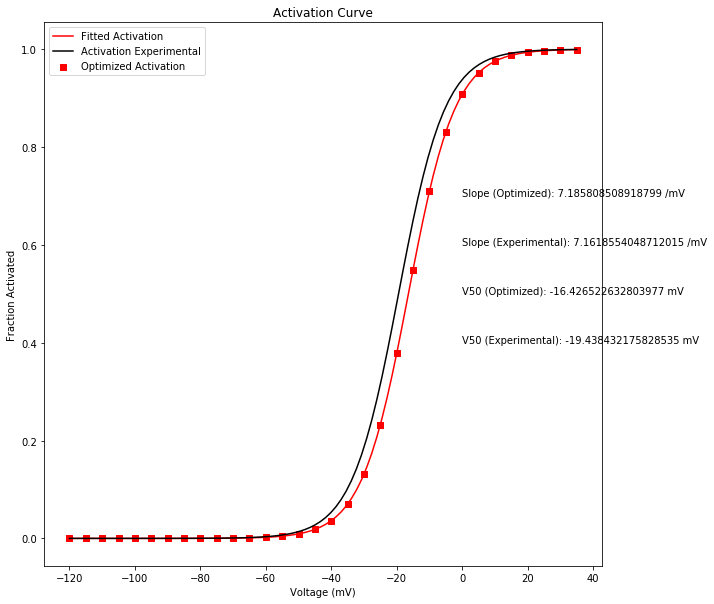

In [9]:
evaluator.plot_act(best_indvs[-1])

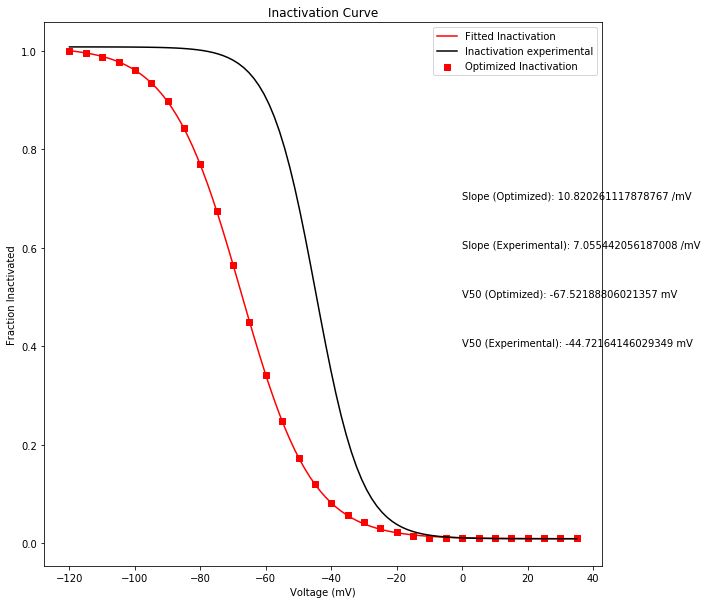

In [21]:
evaluator.plot_inact(best_indvs[-1])

0.01803089019553087
0.9999947231140535
0.002371458641170018
0.8927258721940866
1.1909104890546904
[0.         0.40546511 1.09861229 1.7227666  2.30258509 3.40119738
 4.02535169 4.60517019 5.01063529 5.70378247 6.32793678 6.90775528
 7.9827577  8.51719319]
[0.23384149 0.32330888 0.53370936 0.7554071  0.91788412 0.999423
 0.99999801 0.99999893 0.99999893 0.99999893 0.99999893 0.99999893
 0.99999893 0.99999893]


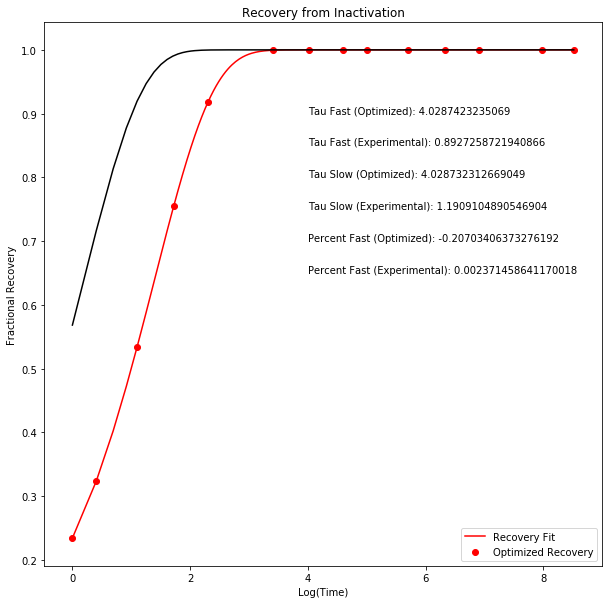

In [8]:
evaluator.plot_rec(best_indvs[-1])

In [10]:
best_indvs

[[13.983681200156708,
  0.41410084301990535,
  0.32071217768962973,
  1.1426791240210248,
  1365.1252682606428,
  1.2395451693043529,
  42.37051667616886,
  2.250779577104819,
  158.0861083951514,
  0.7679073482414933,
  33.984171529485984,
  0.3419487825810961,
  195.1287823069489,
  22.977568617116642,
  0.3141456859785559,
  0.8932394721392023,
  359.8359920463652,
  0.10409979811289098,
  -15.87187945709536,
  19.359067423756006],
 [8.464844681642898,
  2.0307668697817762,
  0.2976005883549606,
  0.15460245274061468,
  343.22671504610224,
  1.193780541793662,
  49.63362714517293,
  2.0380039346716963,
  157.5493943947152,
  0.7684035617293716,
  34.180985524279464,
  0.472093568390449,
  181.8223895866935,
  22.058451580915584,
  2.051849971390642,
  1.0832446535620115,
  800.9531617252901,
  2.1048990342466656,
  -3.7690305178106236,
  17.56073472021274],
 [8.464844681642898,
  2.0307668697817762,
  0.2976005883549606,
  0.15460245274061468,
  343.22671504610224,
  1.1937805417936

In [23]:
even_xs = np.linspace(times[0], times[len(times)-1], 10000)

In [24]:
curve_exp = cf.two_phase(even_xs, 0, 1, 0.002371458641170018, 1/0.8927258721940866, 1/1.1909104890546904)

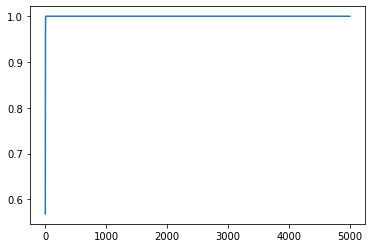

In [25]:
plt.plot(even_xs, curve_exp)

In [17]:
x = [0,        0.40546511, 1.09861229, 1.7227666,  2.30258509, 3.40119738,
 4.02535169, 4.60517019, 5.01063529, 5.70378247, 6.32793678, 6.90775528,
 7.9827577,  8.51719319]
y = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


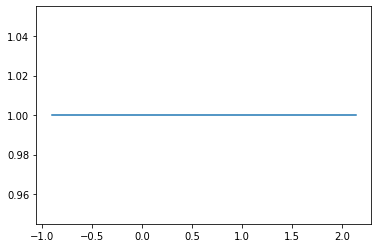

In [19]:
plt.plot(np.log(x), y)

In [20]:
np.log(x)

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([       -inf, -0.90272045,  0.09404783,  0.54393149,  0.83403244,
        1.22412754,  1.39261228,  1.52717963,  1.61156271,  1.74112955,
        1.84497424,  1.93264473,  2.07728393,  2.14208685])

In [22]:
np.log(8.51)

2.1412419425852827